## Scope

Starting point: raw h5ad

Output: filtered h5ad

Requisites:

Optional


## Instructions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import os
import anndata as ad
import squidpy as sq
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Reading and obtaining QC metrics

def annotate(adata):
    # Tutorial looked for NegPrb but files contains "Negative1 " to "Negative9"
    # And "SystemControl1" to "SystemControl197"
    adata.var["NegPrb"] = adata.var_names.str.startswith("Negative")
    adata.var["SystemControl"] = adata.var_names.str.startswith("SystemControl")


def calc_qc(adata, pm):
    
    sc.pp.calculate_qc_metrics(adata, qc_vars = pm["qc_vars"] , inplace=True)
    pct_qc_vars = adata.obs["total_counts_" + pm["qc_vars"][0] ].sum() / adata.obs["total_counts"].sum() * 100
    print("{0} : {1} % of total counts".format(pm["qc_vars"], pct_qc_vars))

  
def view_qc(adata):
    sns.jointplot(
    data=adata.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
    )

In [12]:
# Explore distribution of counts per cell and number of counts per gene

def plot_counts_genes(adata):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].set_title("Total transcripts per cell")
    sns.histplot(
        adata.obs["total_counts"],
        kde=False,
        ax=axs[0],
    )
    
    axs[1].set_title("Unique transcripts per cell")
    sns.histplot(
        adata.obs["n_genes_by_counts"],
        kde=False,
        ax=axs[1],
    )
    
    axs[2].set_title("Transcripts per FOV")
    sns.histplot(
        #breaks in pandas 2 as column 'fov' has type category, no sum possible       
        #adata.obs.groupby("fov").sum()["total_counts"],
        adata.obs.groupby("fov")[["total_counts"]].sum(),
        kde=False,
        ax=axs[2],
    )

def plot_counts_violin(adata):
    sc.pl.violin(
        adata,
        ["total_counts", "n_genes_by_counts","pct_counts_NegPrb" ],
        jitter = 0.1,
        size = 0,
        multi_panel = True,
    )
    

"""
B2M (beta2-microglobulin; in MHC class I complex)  + CD298 (sodium potassiium ATPase_subunit) : broadly expressed, used to barcode live cells (Hartmann et al 2018 Scientific reports)
DAPI : DNA staining to locate cell nuclei 
panCK (pan-cytokeratin) : epithelial cells  
CD45 : hematopoietic cells (immune cells incl. B cells, T cells, NK cells, monocytes, granulocytes)  
PanCK- CD45- : stromal cells
CD3: B cells
"""

def plot_IF(adata): 
    IF_list = ['CD298.B2M', 'DAPI', 'PanCK', 'CD45', 'CD3' ]
    fig, axs = plt.subplots(1, len(IF_list), figsize=(15, 4))
        
    for idx, prot in enumerate(IF_list):
        
        axs[idx].set_title(prot)
        sns.histplot(
            adata.obs["Mean." + prot],
            kde=False,
            ax=axs[idx],
        )

In [13]:
# Filter observations and features based on counts, mitochondrial counts

def filter( adata , pm_cells, pm_genes ):

    inio = adata.n_obs
    print(f"cells before filter: {inio}")
    if "min_counts" in pm_cells.keys() :
        sc.pp.filter_cells(adata, min_counts = pm_cells["min_counts"] )
        print("cells after min_counts filter: {0} ({1:.2%})".format(adata.n_obs, adata.n_obs / inio ))

    if "max_counts" in pm_cells.keys() :
        sc.pp.filter_cells(adata, max_counts = pm_cells["max_counts"] )
        print("cells after max_counts filter: {0} ({1:.2%})".format(adata.n_obs, adata.n_obs / inio ))

    if "min_genes" in pm_cells.keys() :
        sc.pp.filter_cells(adata, min_genes=pm_cells["min_genes"])
        print("cells after min_genes filter: {0} ({1:.2%})".format(adata.n_obs, adata.n_obs / inio ))

    if "max_genes" in pm_cells.keys() :
        sc.pp.filter_cells(adata, max_genes=pm_cells["max_genes"])
        print("cells after max_genes filter: {0} ({1:.2%})".format(adata.n_obs, adata.n_obs / inio ))
        
    if "pct_counts_mt" in pm_cells.keys() :
        adata = adata[adata.obs["pct_counts_mt"] < pm_cells["pct_counts_mt"]].copy()
        print("cells after MT filter: {0} ({1:.2%})".format(adata.n_obs, adata.n_obs / inio))

    if "pct_counts_NegPrb" in pm_cells.keys() :
        adata = adata[adata.obs["pct_counts_NegPrb"] < pm_cells["pct_counts_NegPrb"]].copy()
        print("cells after NegPrb filter: {0} ({1:.2%})".format(adata.n_obs, adata.n_obs / inio))
        
    iniv = adata.n_vars
    print(f"genes before filter: {iniv}")
    if "min_cells" in pm_genes:
        sc.pp.filter_genes(adata, min_cells = pm_genes["min_cells"] )
        print("genes after min_cells filter: {0} ({1:.2%})".format(adata.n_vars, adata.n_vars / iniv ))
   
    return    


In [14]:
# Normalisation (Normlog, Seurat or Pearson residuals), feature reduction, PCA,..
# Harmony, K nearest neighbours, UMAP, Leiden

def norm_log_gene(adata, pm):
    # Normalization of counts
    print("Normalizing counts")
    sc.pp.normalize_total(adata, exclude_highly_expressed=pm["exclude_highly_expressed"], inplace=True)
    # Log(x+1) transformation
    if pm["hvg_method"] in ["seurat", "cell_ranger"]:
        print("Performing log(x+1) transformation of counts")
        sc.pp.log1p(adata)
    return

def hvg_seurat(adata, pm):
    # Selection of highly variable genes
    sc.pp.highly_variable_genes(adata, flavor = pm["hvg_method"] , n_top_genes = pm["num_feat"] )
    return 

def hvg_pearson(adata, pm):
    sc.experimental.pp.highly_variable_genes(adata, theta = pm["theta"], flavor = pm["hvg_method"],  n_top_genes = pm["num_feat"])

def scTransform(adata, pm):
    adata.layers["raw"] = adata.X.copy()
    adata.layers["sqrt_norm"] = np.sqrt(
        sc.pp.normalize_total(adata, inplace = False)["X"]
    )
    sc.experimental.pp.normalize_pearson_residuals(adata, theta = pm["theta"] )
    

def pca(adata, pm):
    # calculate principal components
    print("calculate principal components")
    sc.pp.pca(adata, n_comps = pm["n_comps"], layer = pm["layer"] )
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs=pm["n_comps"], save='')
    return 

def harmony_integration(adata, key):
    print("run harmony integration (multi-threaded")
    sc.external.pp.harmony_integrate(adata, key, basis='X_pca', adjusted_basis="X_pca_harmony")
    return

def neighbors(adata, pm):    
    # k nearest neighbors - default method is umap and metric is euclidian
    # run this after integration to correct batch effectS
    print("Finding k nearest neighbours")
    # use_rep='X'  because of warnings  
    sc.pp.neighbors(adata, n_neighbors = pm["n_neighbors"], n_pcs = pm["n_pcs"], use_rep=pm["use_rep"])
    return

def umap(adata, pm):      
    print("Finding UMAP coordinates")
    # gamma in Scanpy corresponds to repulsion.strength in Seurat, i.e. "weighting applied to negative samples 
    # in low dimensional embedding optimization. Values higher than one will result in greater weight being given to negative samples."
    sc.tl.umap(adata, gamma = pm["gamma"])
    return

def leiden(adata, pm) :
    print("Finding Leiden clusters")
    sc.tl.leiden(adata, resolution = pm["resolution"], key_added="leiden_clusters", directed=False, n_iterations=2 )  
    print("done")
    return

def plot_clust(adata, img_out):
    plt.rcParams["figure.figsize"] = (4, 4)
    clustfig = sc.pl.umap(adata,
            ncols = 4 ,
            color=["total_counts", "n_genes_by_counts", "leiden_clusters"], 
            wspace=0.4,
            return_fig = True,
            legend_loc = "on data"
        )
    clustfig.savefig(img_out, format="png", dpi=1200, bbox_inches = "tight")

In [15]:
def plot_tissue(adata, metric, fovs, showfovs):

    norm = "log"
    
    if metric in adata.obs :
        c_var = adata.obs[metric] + (norm == "log") # add 1 to display 0's in log scale
        print("obs level info for ", metric)
    else:
        c_var = sc.get.obs_df(adata, keys = metric ) + (norm == "log") # add 1 to display 0's in log scale
        print("gene level info for ", metric)
    print(c_var.mean())
    
    import re
    figure, ax = plt.subplots()
    
    mean_cell_area = adata.obs["Area.um2"].mean()
    im = ax.scatter(adata.obs["CenterX_global_px"], adata.obs["CenterY_global_px"],
        c= c_var,
        marker="p" , edgecolors = 'none',
        s = 0.1*adata.obs["Area.um2"]/mean_cell_area, # 0.5, #alpha=0.5, 
        norm = norm,  #"linear", 
        cmap = "vlag", #plasma" ) #"viridis" ) # "vlag")
    )
    ax.set_title(f"{sample} - {metric}")
    ax.set_aspect('equal', 'box')
    ax.set_facecolor('black')
    plt.colorbar(im, fraction=0.03, pad = 0.04)
    
    import matplotlib.ticker as ticker
    from matplotlib.ticker import FuncFormatter
    def um_to_mm(x, pos):
        return '%.0f' % (x / 1e3)
    ax.xaxis.set_major_formatter(FuncFormatter(um_to_mm))
    ax.yaxis.set_major_formatter(FuncFormatter(um_to_mm))
    ax.set_xlabel('x coordinate (mm)')
    ax.set_ylabel('y coordinate (mm)')
    
    if showfovs:
        x_centroids, y_centroids = [], []       
        for i in range(len(fovs["names"])):
            sel = adata.obs[adata.obs.index.str.startswith(fovs["names"][i] + "_")]      
            x_centroids.append(sel['CenterX_global_px'].mean())
            y_centroids.append(sel['CenterY_global_px'].mean())
    
        im2 = ax.scatter(x_centroids, y_centroids,
            s=0, alpha=0.36, marker="s" , c="cyan")
    
        for i in range(len(fovs["names"])):
            ax.annotate( re.sub(slide + '_', '', fovs["names"][i] ), 
                    (x_centroids[i], y_centroids[i]) , 
                    textcoords="offset points", xytext=(0,0), fontsize=4, 
                    fontfamily="sans-serif", color="yellowgreen" #fontweight="bold", 
                    )

    metric_corr = re.sub(r'/','-', metric)
    img_out= f"{sample_dir}IF_images/{slide}.{sample}.{metric_corr}.png"
    print(img_out)
    figure.savefig(img_out, format="png", dpi=900, bbox_inches = "tight")
    return

In [16]:
# Function to plot cells on tissue with colors correspoding to their clusters

def plot_clusters(adata, showfovs):
    mean_cell_area = adata.obs["Area.um2"].mean()
    sizes = 0.1*adata.obs["Area.um2"]/mean_cell_area # 0.5, #alpha=0.5, 
    
    figure, ax = plt.subplots()
    nclusters = len(adata.obs["leiden_clusters"].unique())
    sns.set_palette(sns.color_palette("husl",nclusters ))
    
    sns.scatterplot(data = adata.obs,
                    x = "CenterX_global_px",
                    y = "CenterY_global_px",
                    hue = "leiden_clusters",
                    legend = "full",
                    ax = ax,
                    size = 0.5 , sizes = sizes.tolist(), #alpha=0.36,
                    marker="p" , edgecolors = 'none',
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))

    ax.set_title(f"{sample} - clusters")
    ax.set_aspect('equal', 'box')
    ax.set_facecolor('white')
    #plt.legend(handles = scatter.legend_elements()[0], 
    #           labels = adata_clust.obs["leiden_clusters"].unique().tolist())
    
    import matplotlib.ticker as ticker
    from matplotlib.ticker import FuncFormatter
    def um_to_mm(x, pos):
        return '%.0f' % (x / 1e3)
    ax.xaxis.set_major_formatter(FuncFormatter(um_to_mm))
    ax.yaxis.set_major_formatter(FuncFormatter(um_to_mm))
    ax.set_xlabel('x coordinate (mm)')
    ax.set_ylabel('y coordinate (mm)')
    #legend = ax.legend(*scatter.legend_elements(),
    #          loc="upper right", title="leiden"
    #         )
    #ax.add_artist(legend)

    if showfovs:
        x_centroids, y_centroids = [], []       
        for i in range(len(fovs["names"])):
            sel = adata.obs[adata.obs.index.str.startswith(fovs["names"][i] + "_")]      
            x_centroids.append(sel['CenterX_global_px'].mean())
            y_centroids.append(sel['CenterY_global_px'].mean())
    
        im2 = ax.scatter(x_centroids, y_centroids,
            s=0, alpha=0.36, marker="s" , c="cyan")
    
        for i in range(len(fovs["names"])):
            ax.annotate( re.sub(slide + '_', '', fovs["names"][i] ), 
                    (x_centroids[i], y_centroids[i]) , 
                    textcoords="offset points", xytext=(0,0), fontsize=4, 
                    fontfamily="sans-serif", color="yellowgreen" #fontweight="bold", 
                    )
            
    img_out= f"{sample_dir}IF_images/{slide}.{sample}.clusters.{pm_recap}.png"
    print(img_out)
    figure.savefig(img_out, format="png", dpi=1200, bbox_inches = "tight")


## START HERE

In [17]:
sample_dir = "/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/"
mapping_f = "FOV_mapping_corrected_v3.tsv"
mapping_s = "slide_mapping.tsv"
  
conditions = pd.read_csv(sample_dir + mapping_s, header=0, sep="\t")

#slide = "TOM1"
#samples = ["TP_N1_m2_spleen","TP_2_m1_spleen", "TP_2_m1_bone_marrow"]
slide = "TOM2"
samples = ["TP_3_m2_spleen","TP_4_m2_spleen","TP_3_bone_marrow", "TP_N1_m2_lymph_node", "TP_4_m7_lymph_node"]
sample = samples[3]

fovs_to_s = {}
fovs_to_s["TP_N1_m2_spleen"] = ["174", "175", "176", "177", "143", "181", "182", "183", "189", "190", "196", "197"]
fovs_to_s["TP_2_m1_spleen"] = ["67", "68", "69", "78", "79", "80", "89", "90", "91", "100", "101", "102"]
fovs_to_s["TP_3_m2_spleen"] = ["81", "82", "83", "84", "85", "93", "94", "95", "96", "97", "104", "105"]
fovs_to_s["TP_4_m2_spleen"] = ["143", "144", "145", "146", "147", "151", "152", "161", "162", "171", "172", "173"]


in_hd5f = sample + "_raw.hdf5"

pm={}
#pos_file = f"{sample_dir}{slide_orig}/{slide_orig}_fov_positions_file.csv"
#img_file = f"{sample_dir}IF_images/{slide}_IF.jpg"

print("Processing slide ", slide) 

adata = ad.read_h5ad(f"{sample_dir}{slide}/{in_hd5f}")
adata

Processing slide  TOM2


AnnData object with n_obs × n_vars = 23749 × 1194
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD3', 'Max.CD3', 'Mean.CD298.B2M', 'Max.CD298.B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'slide_name', 'sample', 'time_point', 'mouse', 'tissue', 'dataset'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_fov'

In [18]:
# Annotate the fovs
adata.obs["slide_fov"] = slide + "_" + adata.obs["fov"].astype(str)
adata.obs["slide_fov"] = adata.obs["slide_fov"].astype('category')

#tgt_file = 
#adaata.write(filename= tgt_file)

fovs = adata.obs["fov"].unique()
xcoord = [ adata.uns["spatial"][slide + "_" + str(fov)]["metadata"]['X_mm'] for fov in fovs]
ycoord = [ adata.uns["spatial"][slide + "_" + str(fov)]["metadata"]['Y_mm'] for fov in fovs]
names = [slide + "_" + str(fov) for fov in fovs]
fovs = { "x" : xcoord, "y": ycoord, "names" : names }


## mapping of stromal cells did not work as planned, signal everywhere
#adata.obs["PanCK- CD45-"] = adata.obs["Mean.PanCK"] *  adata.obs["Mean.CD45"]
#maxpancd = adata.obs["PanCK- CD45-"].max()
#adata.obs["PanCK- CD45-"] = 1 + (maxpancd - adata.obs["PanCK- CD45-"])

"""
adata.obs["Cd3d_e_g"] = sc.get.obs_df(adata, keys = ["Cd3d", "Cd3e", "Cd3g"]).sum(axis =1)
adata.obs["Gzma_b"] = sc.get.obs_df(adata, keys = ["Gzma", "Gzmb"]).sum(axis =1)
adata.obs["S100a8_9"] = sc.get.obs_df(adata, keys = ["S100a8", "S100a9"]).sum(axis =1)
adata.obs["Hba1_a2_b"] = sc.get.obs_df(adata, keys = ["Hba-a1/2", "Hbb"]).sum(axis =1)
"""

'\nadata.obs["Cd3d_e_g"] = sc.get.obs_df(adata, keys = ["Cd3d", "Cd3e", "Cd3g"]).sum(axis =1)\nadata.obs["Gzma_b"] = sc.get.obs_df(adata, keys = ["Gzma", "Gzmb"]).sum(axis =1)\nadata.obs["S100a8_9"] = sc.get.obs_df(adata, keys = ["S100a8", "S100a9"]).sum(axis =1)\nadata.obs["Hba1_a2_b"] = sc.get.obs_df(adata, keys = ["Hba-a1/2", "Hbb"]).sum(axis =1)\n'

obs level info for  nCount_RNA
45.95275590551181
/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/TOM2.TP_N1_m2_lymph_node.nCount_RNA.png
obs level info for  Mean.CD298.B2M
900.828119078698
/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/TOM2.TP_N1_m2_lymph_node.Mean.CD298.B2M.png
obs level info for  Mean.PanCK
228.68861846814602
/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/TOM2.TP_N1_m2_lymph_node.Mean.PanCK.png
obs level info for  Mean.DAPI
1940.5804033854056
/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/TOM2.TP_N1_m2_lymph_node.Mean.DAPI.png
obs level info for  Mean.CD45
1239.6479009642512
/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/TOM2.TP_N1_m2_lymph_node.Mean.CD45.png
obs level info for  Mean.CD3
213.92037559476188
/mnt/share/Projects/Proj_AN1_P.chabaudi/Datasets/CosmX/IF_images/TOM2.TP_N1_m2_lymph_node.Mean.CD3.png


KeyError: "Could not find keys '['Hba1_a2_b']' in columns of `adata.obs` or in adata.var_names."

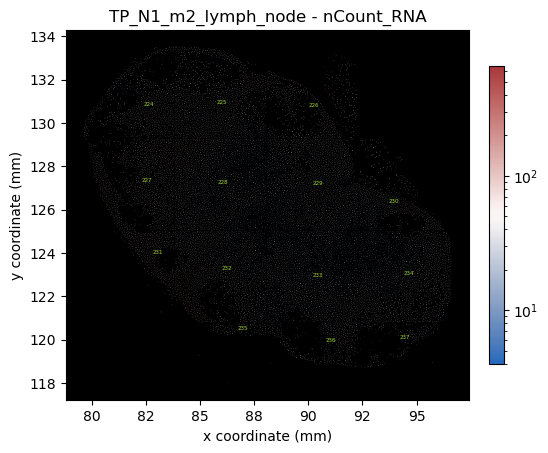

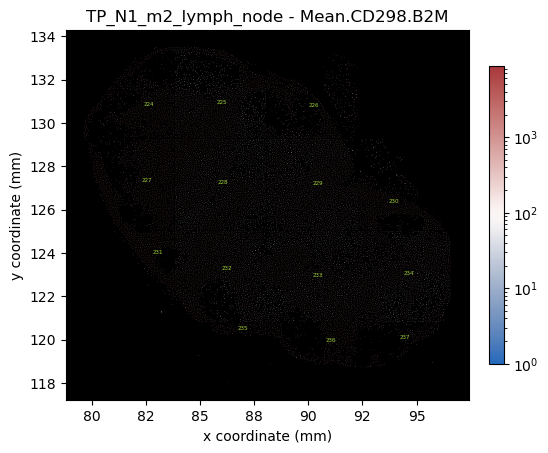

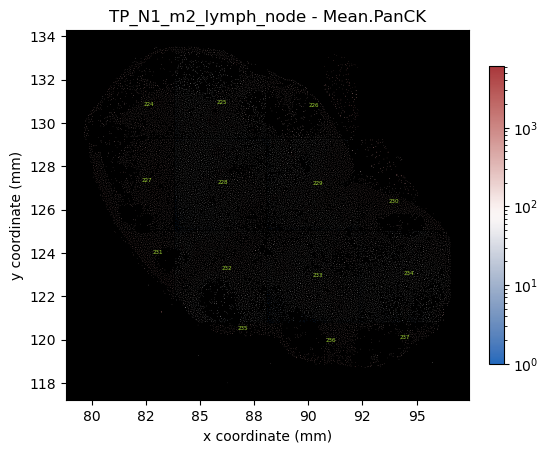

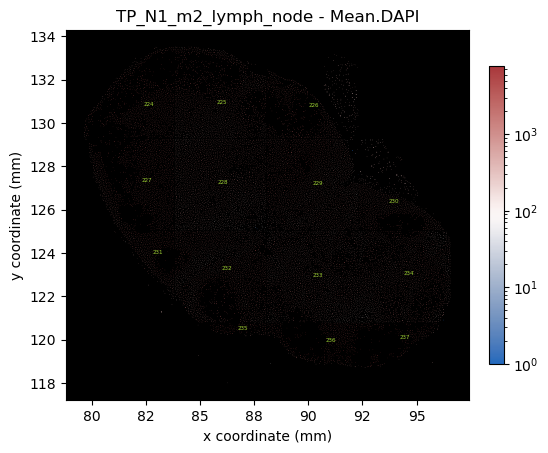

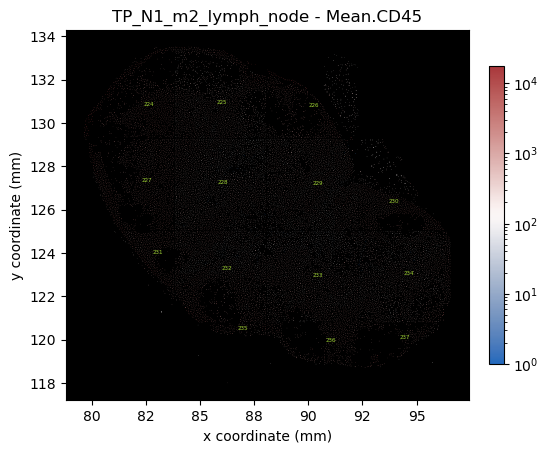

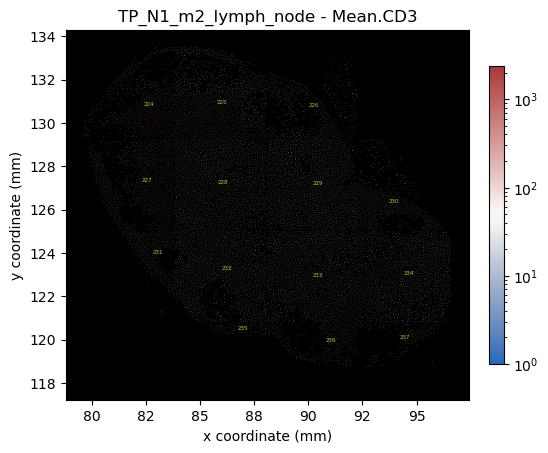

In [19]:
# Plot total RNAs and Immunofluorescent markers/cell
"""
Beta2-microglobulin; in MHC class I complex)  + CD298 (sodium potassiium ATPase_subunit) : broadly expressed
DAPI : DNA staining to locate cell nuclei 
panCK (pan-cytokeratin) : epithelial cells  
CD45 : nucleated hematopoietic cells (immune cells incl. B cells, T cells, NK cells, monocytes, granulocytes..)  - negative on RBCs, their precursors, megakaryocytes, osteoblasts, platelets
PanCK- CD45- : stromal cells  (only in bone marrow)
CD3 : T cells
"""

vars_to_plot = ["nCount_RNA","Mean.CD298.B2M", "Mean.PanCK",'Mean.DAPI', "Mean.CD45", 'Mean.CD3'] # "PanCK- CD45-", 
for var in vars_to_plot:
    plot_tissue(adata, var, fovs, showfovs = True)

# Hba1_a2_b, Cd79a
vars_to_plot = ["Hba1_a2_b"]
for var in vars_to_plot:
    plot_tissue(adata, var, fovs, showfovs=True)

In [12]:
# Identify columns corresponding to Negative Probes ("Negative1 " to "Negative9")
# or System controls ("SystemControl1" to "SystemControl197")
annotate(adata)

non_syst_ctrl = [name for name in adata.var_names if not name.startswith("SystemControl")]
adata_nosys = adata[:, non_syst_ctrl]
print(adata_nosys)

# Run Scanpy's calculate_qc_metrics on Negative probes
pm_qc = { "var_type" : "genes", "qc_vars" : ["NegPrb"]}
# Display QC plots 
calc_qc(adata_nosys, pm_qc)
print(adata_nosys)
#view_qc(adata)

non_neg = [name for name in adata_nosys.var_names if not name.startswith("Negative")]
adata_nosysneg = adata_nosys[:, non_neg]
print(adata_nosysneg)

View of AnnData object with n_obs × n_vars = 367294 × 1010
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD3', 'Max.CD3', 'Mean.CD298.B2M', 'Max.CD298.B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'slide_name', 'sample', 'time_point', 'mouse', 'tissue', 'dataset', 'slide_fov', 'Cd3d_e_g', 'Gzma_b', 'S100a8_9', 'Hba1_a2_b'
    var: 'NegPrb', 'SystemControl'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_fov'
['NegPrb'] : 0.5317032495658389 % of total counts
AnnData object with n_obs × n_vars = 367294 × 1010
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.

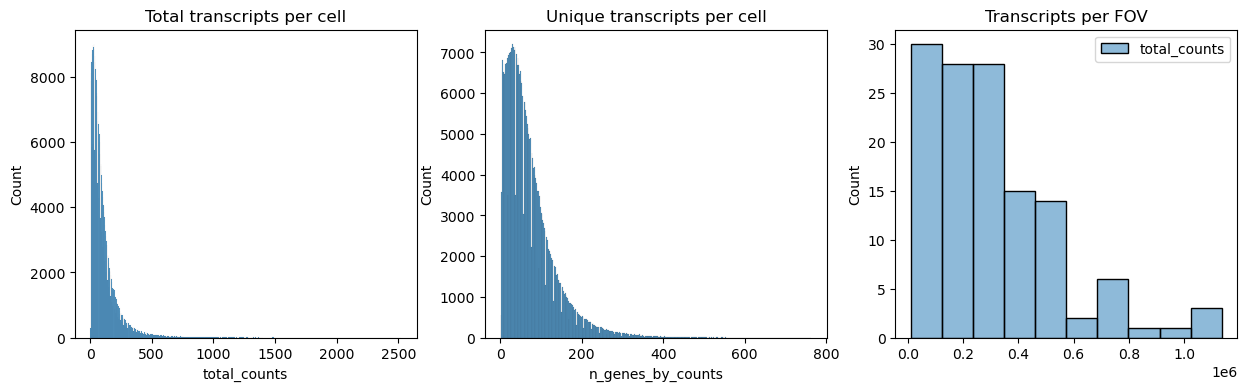

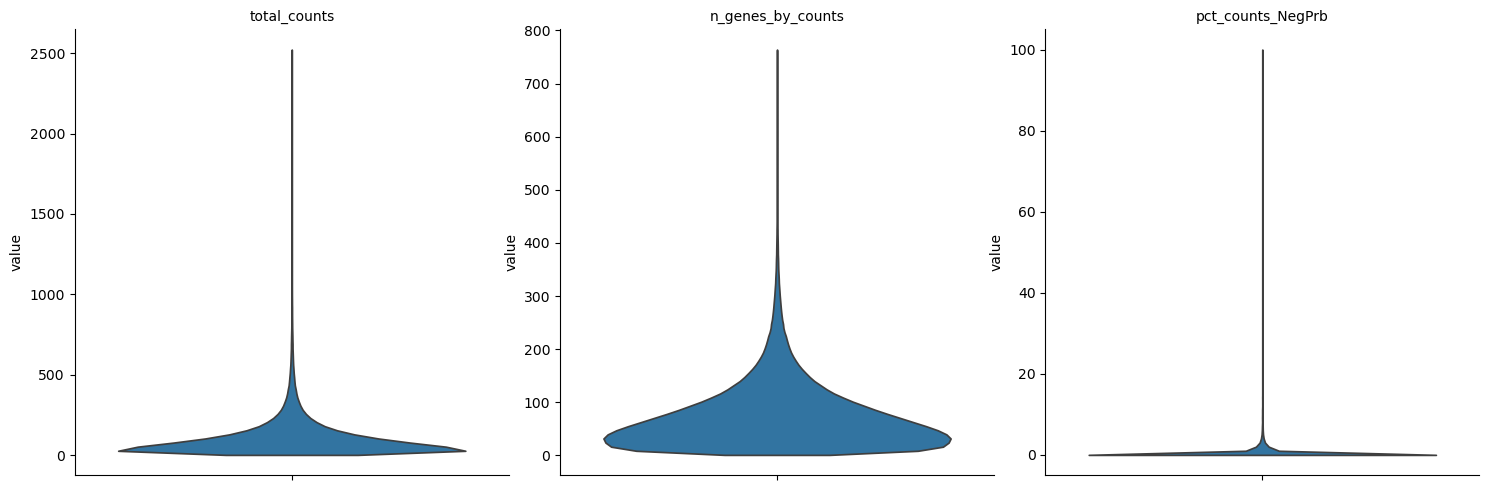

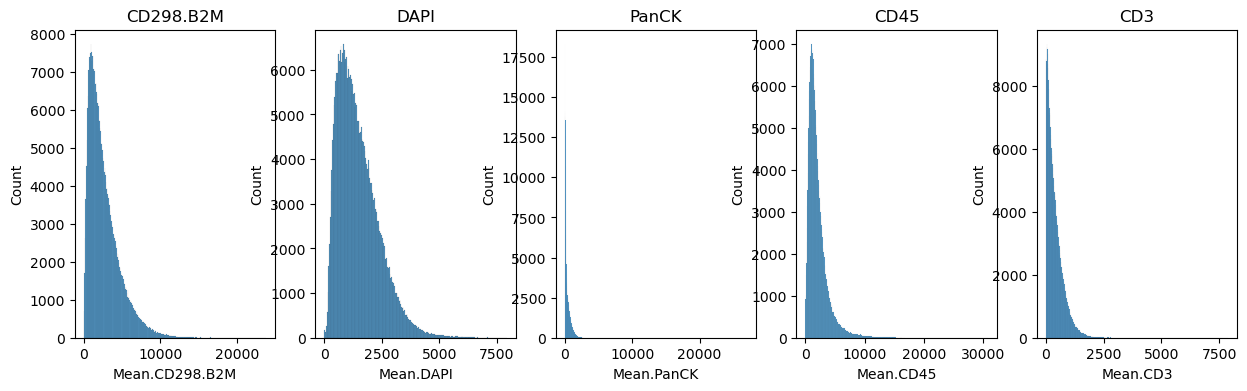

In [13]:
plot_counts_genes(adata_nosysneg)
plot_counts_violin(adata_nosysneg)
plot_IF(adata_nosysneg)

## Filtering observations (eg. cells) and features (eg. genes)


cells before filter: 367294
cells after min_counts filter: 353443 (96.23%)
cells after max_counts filter: 331927 (90.37%)
cells after min_genes filter: 324825 (88.44%)
cells after max_genes filter: 308840 (84.09%)
cells after NegPrb filter: 307901 (83.83%)
genes before filter: 1000
genes after min_cells filter: 1000 (100.00%)


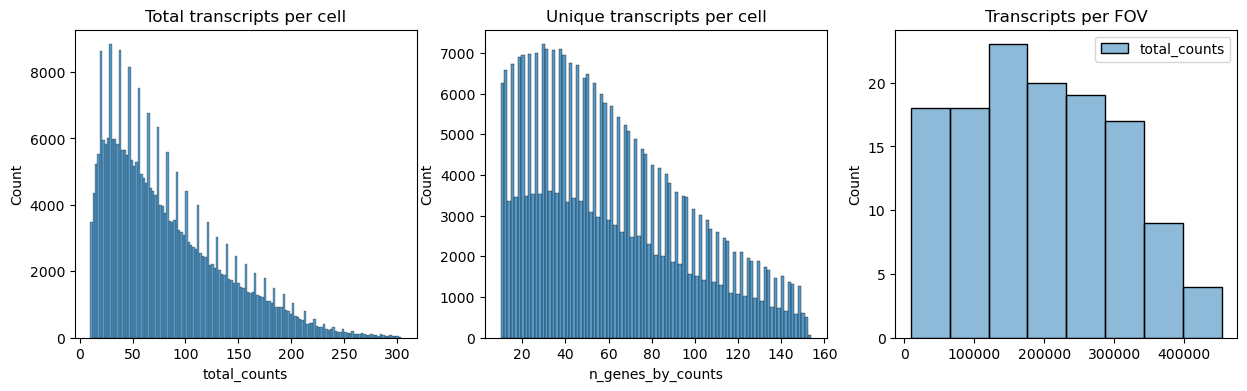

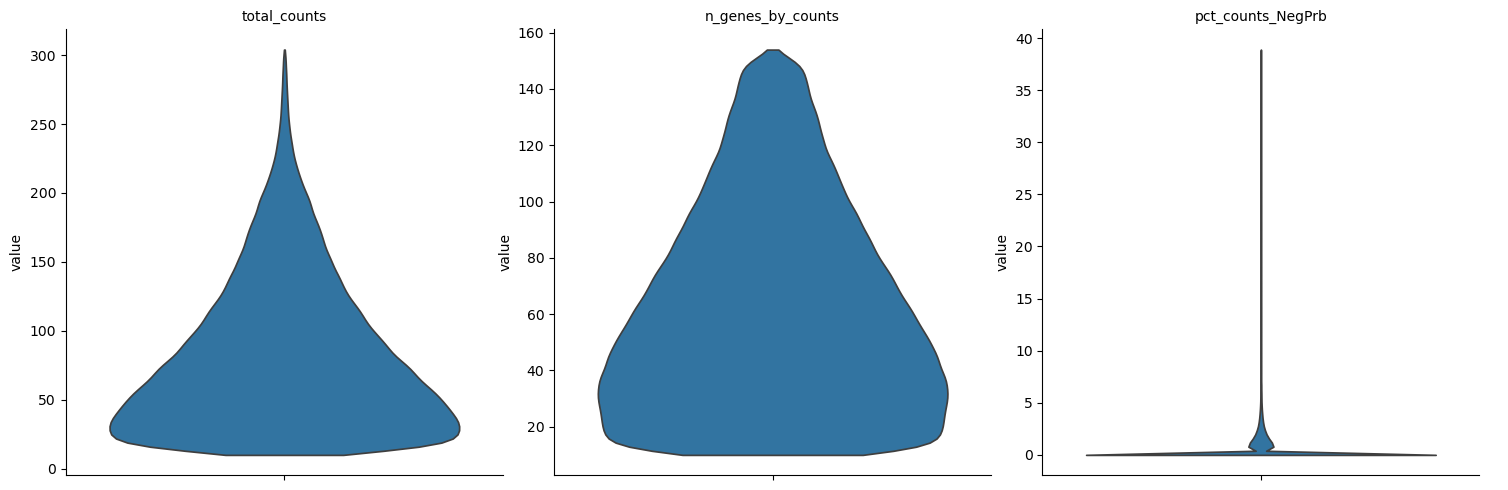

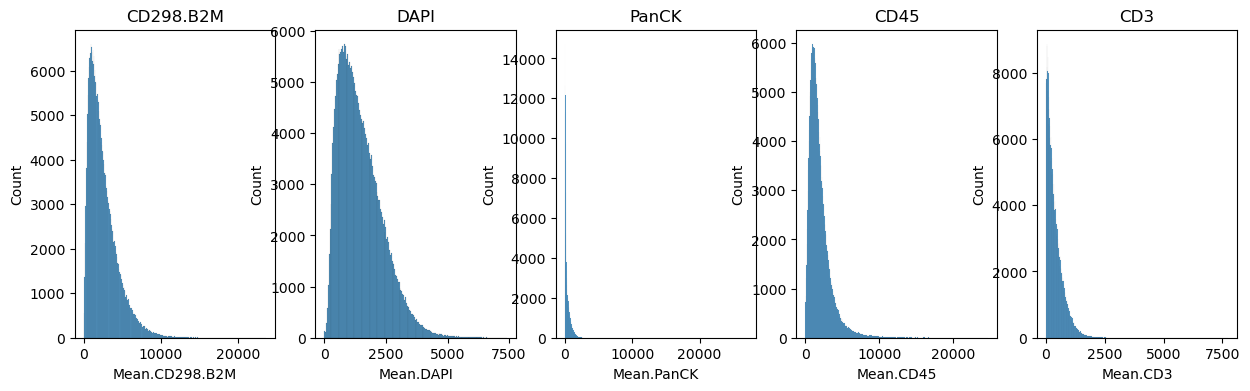

In [14]:
pm_filter_cells = { 
    "min_counts" : 10, "max_counts" : 300, 
    "min_genes" : 10 , "max_genes": 150,
    "pct_counts_NegPrb" : 10 } #, "pct_counts_mt" : 20,
pm_filter_genes = {"min_cells" : 100 }
pm["pm_filter_cells"] = pm_filter_cells
pm["pm_filter_genes"] = pm_filter_genes

adata_fltr = adata_nosysneg.copy()

filter(adata_fltr , pm_filter_cells, pm_filter_genes)
plot_counts_genes(adata_fltr )
plot_counts_violin(adata_fltr)
plot_IF(adata_fltr)

## Save filtered whole sample and selected FOVs

In [ ]:
# Save the annData as hdf5 for later loading
tgt_file = f"{sample_dir}{slide}/{sample}_filtered.hdf5"
adata_fltr.write( filename= tgt_file)

In [16]:
# select some FOVs to analyse

fovs_to_select = [ slide + "_" + fov for fov in fovs_to_s[sample] ]
print(fovs_to_select)
adata_fltr_fovs = adata_fltr[adata_fltr.obs["slide_fov"].isin(fovs_to_select) ].copy()

print(adata_fltr_fovs)
tgt_file = f"{sample_dir}{slide}/{sample}_filtered_selected.hdf5"
adata_fltr_fovs.write(filename = tgt_file)

['TOM1_67', 'TOM1_68', 'TOM1_69', 'TOM1_78', 'TOM1_79', 'TOM1_80', 'TOM1_89', 'TOM1_90', 'TOM1_91', 'TOM1_100', 'TOM1_101', 'TOM1_102']
AnnData object with n_obs × n_vars = 32935 × 1000
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD3', 'Max.CD3', 'Mean.CD298.B2M', 'Max.CD298.B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'slide_name', 'sample', 'time_point', 'mouse', 'tissue', 'dataset', 'slide_fov', 'Cd3d_e_g', 'Gzma_b', 'S100a8_9', 'Hba1_a2_b', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_c

## PCA, normalisation, clustering, DE etc..

In [ ]:
# Set parameters for normalisation, feature reduction, dimensionality reduction, clustering...

normalization = ["log", "sctransform"][1]

if normalization == "log" :
    pm_normlog = {"exclude_highly_expressed": False, "reduce" : False, "hvg_method" : "seurat", "num_feat" : 300 }
    pm["pm_normlog"] = pm_normlog
elif normalization == "sctransform" :
    # theta np.Inf when Poisson distribution of counts is expected, else 100 as default for negative binomial 
    pm_sctransform = {"theta" : np.Inf, "hvg_method" : "pearson_residuals", "num_feat" : 1000 }
    pm["pm_sctransform"] = pm_sctransform

pm_pca = {"n_comps" : 50 , "layer" : None }
pm_harmony = {"key" : "slide_fov"}
pm_neighbors =  { "n_neighbors" : 20 , "n_pcs" : 20, "use_rep" : "X_pca_harmony"} 
# gamma in Scanpy corresponds to repulsion.strength in Seurat, i.e. "weighting applied to negative samples 
# in low dimensional embedding optimization. Values higher than one will result in greater weight being given to negative samples."
pm_umap = {"gamma" : 10 }
pm_leiden = { "resolution" : 1 }


In [ ]:
# Normalize, reduce, cluster

# store in pm dict for export - TO DO

pm_recap = f"{normalization}_{pm_sctransform['num_feat']}" \
    f"_{pm_pca['n_comps']}_{pm_neighbors['n_neighbors']}_{pm_neighbors['n_pcs']}" \
    f"_{pm_umap['gamma']}_{pm_leiden['resolution']}"

pm["pm_neighbors"] = pm_neighbors
pm["pm_umap"] = pm_umap
pm["pm_leiden"] = pm_leiden

try: 
    del adata_clust
except:
    print("no adata_clust yet")

adata_clust = adata_fltr_fovs.copy()
adata_clust.layers["counts"] = adata_clust.X.copy()

if normalization == "log" :
    norm_log_gene(adata_clust, pm_normlog)
    if pm_normlog["reduce"] :
        hvg_seurat(adata_clust, pm_normlog)
elif normalization == "sctransform" :
    hvg_pearson(adata_clust, pm_sctransform)
    scTransform(adata_clust, pm_sctransform)

# Else PCA directly, not on highly variable genes (see https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_nanostring.html#calculate-quality-control-metrics)
%timeit -n 1 -r 1 pca(adata_clust, pm_pca)

import harmonypy as hm
ho = hm.run_harmony(data_mat = adata_clust.obsm["X_pca"], meta_data = adata_clust.obs, vars_use = pm_harmony["key"] )
pc_std = np.std(ho.Z_corr, axis = 1).tolist()
sns.scatterplot(x=range(0, len(pc_std)), y=sorted(pc_std, reverse=True))
adata_clust.obsm["X_pca_harmony"] = ho.Z_corr.transpose()

%timeit -n 1 -r 1 neighbors(adata_clust, pm_neighbors)
%timeit -n 1 -r 1 umap(adata_clust, pm_umap)
%timeit -n 1 -r 1 leiden(adata_clust, pm_leiden)

img_out= f"{sample_dir}IF_images/{slide}.{sample}.umaps.{pm_recap}.png"
print(img_out)
plot_clust(adata_clust, img_out)


In [ ]:
ngenes = 20
sc.tl.rank_genes_groups(adata_clust, groupby="leiden_clusters", ngenes = ngenes , method="wilcoxon", key="rank_genes_groups")

clusters = adata_clust.obs["leiden_clusters"].unique().tolist()
df = sc.get.rank_genes_groups_df(adata_clust, group= clusters, key="rank_genes_groups" )
df.groupby("group").head(ngenes).to_csv(f"{sample_dir}{slide}/{sample}_{ngenes}_rankgenes.csv")

img_out= f"{slide}.{sample}.{pm_recap}.png"

sc.settings.datasetdir =  f"{sample_dir}IF_images/"
sc.pl.rank_genes_groups(adata_clust, save = img_out)
sc.pl.rank_genes_groups_dotplot(adata_clust)

In [ ]:
#SPascer
# CellMarker
# sctype

In [ ]:
# TOM1 TP_N1
types_TOM1_TP_N1  = {
    "0" : "CD8+ T cells", #Cd3a/b/d, Cd8a/b1, MS4ab, Gzma, Gzmb
    "1" : "Mature B cells",
    "2" : "Other",
    "3" : "Fibroblast", #Bgn, Col1a1, Col1a2
    "4" : "Granulocytes", # Csk
    "5" : "Macrophages", #Psap, C1qa, C1qb
    "6" : "Dendritic cells ?", #Mt1, Mt2
    "7" : "Naive B cells", #Ighm
    "8" : "Neutrophils", #s100a8, s100a9, MMp9
    "9" : "X? B cells", # Igkc, Xbp1
    "10" : "X? B cells", #Ighm, Igkc, Xbp1
    "11" : "Hematopoietic stem cells ?", #Meg3
    "12" : "Other",
    "13" : "Fibroblast/stromal cells", # Col12a1
    "14" : "Effector B cells", #Ighg1
    "15" : "Effector B cells", #Igha
    "16" : "Macrophages or monocytes?", #CCl4
    "17" : "CD4+ Tregs", #PParg
    "18" : "Other",
    "19" : "Plasma/MZ? B cells", #Mzb1
    "20" : "X? B cells", #Igkc, Selenop
    "21" : "Neutrophils", #s100a8, s100a9
}



In [ ]:
: "Neutrophils", # Mpo, Elane, Prtn3, S100a8, S100a9
: ""

In [ ]:
adata_clust[adata_clust.obs["leiden_clusters"].isin(["1"]) ]

In [ ]:
adata_clust.obs["leiden_clusters"].value_counts()

In [ ]:
clusters_to_show = ["0", "1", "2"]
plot_clusters(adata_clust[adata_clust.obs["leiden_clusters"].isin(clusters_to_show)], showfovs = False)

In [ ]:
import re
plot_clusters(adata_clust, showfovs = False)



sc.pl.umap(
    adata_clust,
    color = ["leiden_clusters"],
    legend_loc = "on data"
)

In [ ]:
prots = ['Mean.DAPI', 'Mean.PanCK', 'Mean.CD45', 'Mean.CD298.B2M', 'Mean.CD3', 'nCount_RNA' ]
"""
panCK (pan-cytokeratin) : epithelial cells
CD45 : hematopoietic cells (immune cells incl. B cells, T cells, NK cells, monocytes, granulocytes)
PanCK- CD45- : stromal cells
DAPI : DNA staining to locate cell nuclei
B2M (beta2-microglobulin)
CD298 
"""
for pr in prots: 
    #print(f"{pr.upper()}:")
    sq.pl.spatial_scatter(
        adata_fltr,
        color=pr,
        library_key="slide_fov",
        library_id=[f"{slide}_136", f"{slide}_137", f"{slide}_138", f"{slide}_139" ],
        spatial_key="spatial",
        seg_cell_id="cell_ID",
        img=False,
        size=85,
        shape="hex"
    )

In [ ]:
vars_to_plot = ["Gzmab"] #Mean.DAPI"] #["Cd74", "S100a8", "S100a9", "Hbb", "Hba-a1/2", "Max.PanCK"]
for var in vars_to_plot:
    plot_tissue(adata, var, fovs, showfovs=True)


In [ ]:
sc.get.obs_df(adata_clust, keys = "S100a8")

In [ ]:
markers = {}

markers["Erythroblasts"] = ["Hbb", "Hba-a1/2"]

markers["Macrophages"] = ["Cd14", "Cd163"]
# macrophages: 
markers["NK cells"] = ["Cd38"]

markers["CD8+ T cells"] = ["Cd3d", "Cd3e", "Cd3g", "Cd8a", "Cd8b1"]
markers["CD4+ T cells"] = ["Cd3d", "Cd3e", "Cd3g", "Cd4"]
markers["Treg cells"] = ["Cd3d", "Cd3e", "Cd3g", "Foxp3"]

markers["B cells"] = ["Cd74", "Cd79a"]

"""
markers["HSPCs"] = ["Prss34", "Angpt1", "Adgrl4", "Nrxn1","Cpa3"]
markers["Pro-Erythroblasts"] = ["Mki67"]

markers["Pre-B cells"] = ["Vpreb3","Cd79a","Ighm", "Ly6d"]
markers["Pro-B cells"] = ["Ezh2", "Vpreb3", "Myl4", "Il7r"]
markers["B cells"] = ["Cd74", "Cd79a", "Ikzf3", "Ms4a1", "Ly6d"]
markers["CD8+ T cells"] = ["Cd3g", "Cd3d", "Cd3e", "Cd8a", "Cd8b1", "Ms4a4b", "Itk"]
markers["CD4+ T cells"] = ["Cd3g", "Cd3d", "Cd3e", "Cd4", "Ms4a4b","Tox","Itk"]
markers["NK cells"] = ["Ccl5", "Nkg7", "Ms4a4b", "Il2rb", "Fyn"]

markers["Monocytes"] = ["Prtn3","Elane", "Ctsg", "Lgals1", "S100a10"]
markers["Macrophages"] = [ "S100a4", "Ccr2", "Fn1", "Apoe", "Crip1"]
markers["DCs"] = ["Bst2","Ly6d", "Lair1", "Fyn"]

markers["Neutrophil Progenitors"] = ["Camp", "Ltf", "Lcn2", "Dstn", "Ncam1"]
markers["Neutrophils"] = ["Mmp9", "S100a6", "S100a9", "S100a8","Lcn2", "Csf3r", "Slpi"]

"""

for ct in markers :
    print(f"{ct.upper()}:")
    sc.pl.umap(
        adata_clust,
        color= markers[ct],
        vmin = 0,
        vmax = "p99",
        sort_order=False,
        frameon=False,
        cmap="YlOrBr", #"Wistia",
        legend_loc = "on data"
)

In [ ]:
sq.pl.spatial_scatter(
    adata_clust,
    color="Max.PanCK",
    library_key="slide_fov",
    library_id=["TOM1_155", "TOM1_156", "TOM1_157", "TOM1_158"],
    spatial_key="spatial",
    seg_cell_id="cell_ID",
    img=False,
    size=65,
    shape="hex"
)

In [ ]:
sq.pl.spatial_scatter(
    adata_clust,
    color="leiden_clusters",
    library_key="slide_fov",
    library_id=["TOM1_128","TOM1_129","TOM1_130", "TOM1_131", "TOM1_155", "TOM1_156", "TOM1_157", "TOM1_158"],
    spatial_key="spatial",
    seg_cell_id="cell_ID",
    img=False,
    size=85,
    shape="hex",
    hspace=0, wspace=0, title="", axis_label=None
)

In [ ]:
sq.pl.spatial_segment(
    adata_temp,
    color="Max.PanCK",
    library_key="fov",
    library_id=["1","2","3"],
    spatial_key="spatial",
    seg_cell_id="cell_ID",
    img=False,
    size=100,
    shape="hex"
)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sq.pl.spatial_segment(
    adata_temp,
    shape="hex",
    color="leiden_clusters",
    library_key="fov",
    library_id="1",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata_temp,
    color="leiden_clusters",
    seg_cell_id="cell_ID",
    library_key="fov",
    library_id="10",
    img=False,
    size=60,
    ax=ax[1],
)
sq.pl.spatial_segment(
    adata_temp,
    color="Max.PanCK",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False
)